In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
from pathlib import Path
from ms_pred.common.plot_utils import *

import tdc
from rdkit.Chem import Descriptors
from ms_pred import common
import pickle
import json

set_style()

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataset_names = ["nist20", "canopus_train_public"]
split_names = ["split_1.tsv", "scaffold_1.tsv"]
name_to_df = {}
for dataset_name in dataset_names:
    data_folder = Path(f"../data/spec_datasets/{dataset_name}/")
    labels = data_folder / "labels.tsv"
    df = pd.read_csv(labels, sep="\t")
    name_to_df[dataset_name] = df
    # print len of df  in nice f string
    print(f"Len of {dataset_name}: {df.shape[0]:,}")

    # get the intersection of the inchikeys
    grouped_ikeys = df.groupby("inchikey").count()
    # Print shape
    print(f"Len of {dataset_name} after inchikey grouping: {grouped_ikeys.shape[0]:,}")
    # Get intersection of formula
    grouped_formula = df.groupby("formula").count()
    # Print shape
    print(f"Len of {dataset_name} after formula grouping: {grouped_formula.shape[0]:,}")

    # Get intersection of ionization
    grouped_ions = df.groupby("ionization").count()
    # Print shape
    print(f"Len of {dataset_name} after ionization grouping: {grouped_ions.shape[0]:,}")
    print(f"{grouped_ions.index}")

    # Print split details
    for split_name in split_names:
        split = data_folder / f"splits/{split_name}"
        if split.exists():
            split_df = pd.read_csv(split, sep="\t")
            split_ct = split_df.groupby("Fold_0").count()
            # Pretty print  the full ct df
            print(f"Split details for {dataset_name} {split_name}")

            print(split_ct)

Len of nist20: 35,129
Len of nist20 after inchikey grouping: 24,403
Len of nist20 after formula grouping: 12,975
Len of nist20 after ionization grouping: 6
Index(['[M+H-2H2O]+', '[M+H-H2O]+', '[M+H]+', '[M+K]+', '[M+NH4]+', '[M+Na]+'], dtype='object', name='ionization')
Split details for nist20 split_1.tsv
         spec
Fold_0       
test     3544
train   28420
val      3165
Split details for nist20 scaffold_1.tsv
         spec
Fold_0       
test     3512
train   28105
val      3512
Len of canopus_train_public: 10,709
Len of canopus_train_public after inchikey grouping: 8,553
Len of canopus_train_public after formula grouping: 5,433
Len of canopus_train_public after ionization grouping: 7
Index(['[M+H3N+H]+', '[M+H]+', '[M+K]+', '[M+Na]+', '[M-H2O+H]+',
       '[M-H4O2+H]+', '[M]+'],
      dtype='object', name='ionization')
Split details for canopus_train_public split_1.tsv
        spec
Fold_0      
test    1040
train   8680
val      989


Saved output:

```
Len of nist20: 35,129
Len of nist20 after inchikey grouping: 24,403
Len of nist20 after formula grouping: 12,975
Len of nist20 after ionization grouping: 6
Index(['[M+H-2H2O]+', '[M+H-H2O]+', '[M+H]+', '[M+K]+', '[M+NH4]+', '[M+Na]+'], dtype='object', name='ionization')
Split details for nist20 split_1.tsv
         spec
Fold_0       
test     3544
train   28420
val      3165
Split details for nist20 scaffold_1.tsv
         spec
Fold_0       
test     3512
train   28105
val      3512
Len of canopus_train_public: 10,709
Len of canopus_train_public after inchikey grouping: 8,553
Len of canopus_train_public after formula grouping: 5,433
Len of canopus_train_public after ionization grouping: 7
Index(['[M+H3N+H]+', '[M+H]+', '[M+K]+', '[M+Na]+', '[M-H2O+H]+',
       '[M-H4O2+H]+', '[M]+'],
      dtype='object', name='ionization')
Split details for canopus_train_public split_1.tsv
        spec
Fold_0      
test    1040
train   8680
val      989
```


## Compute dataset stats

In [3]:
res_folder = f"../results/figs_scarf/dataset_stats/"
res_folder = Path(res_folder)
res_folder.mkdir(parents=True, exist_ok=True)

In [4]:
dataset_names = ["nist20", "canopus_train_public"]
full_df = []
for dataset_name in dataset_names:
    data_folder = Path(f"../data/spec_datasets/{dataset_name}/")
    labels = data_folder / "labels.tsv"
    df = pd.read_csv(labels, sep="\t")
    full_df.append(df)
full_df = pd.concat(full_df)

In [5]:
# First plot distribution of compound sizes
oracle = tdc.oracles.Oracle(name="SA")


def calc_molweight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol)


mol_weights = common.chunked_parallel(full_df["smiles"].values, calc_molweight)
smi_to_weight = {
    smiles: weight for smiles, weight in zip(full_df["smiles"].values, mol_weights)
}

# Reformat this block to adhere to smi_to_weight convention above
sa_scores = common.chunked_parallel(full_df["smiles"].values, lambda x: oracle(x))
smi_to_sa = {smiles: sa for smiles, sa in zip(full_df["smiles"].values, sa_scores)}

Found local copy...Found local copy...
Found local copy...
Found local copy...
Found local copy...
Found local copy...Found local copy...
Found local copy...

Found local copy...
Found local copy...
Found local copy...
Found local copy...

Found local copy...
Found local copy...
Found local copy...
Found local copy...


In [6]:
full_df["sa_score"] = full_df["smiles"].apply(lambda x: smi_to_sa[x])
full_df["mol_wt"] = full_df["smiles"].apply(lambda x: smi_to_weight[x])

In [7]:
# Report mean SA score on dataset name
sa_means = full_df.groupby("dataset").mean()["sa_score"]
weight_means = full_df.groupby("dataset").mean()["mol_wt"]
display(sa_means), display(weight_means)

dataset
canopus_train    3.752264
nist2020         3.014948
Name: sa_score, dtype: float64

dataset
canopus_train    412.748676
nist2020         316.896013
Name: mol_wt, dtype: float64

(None, None)

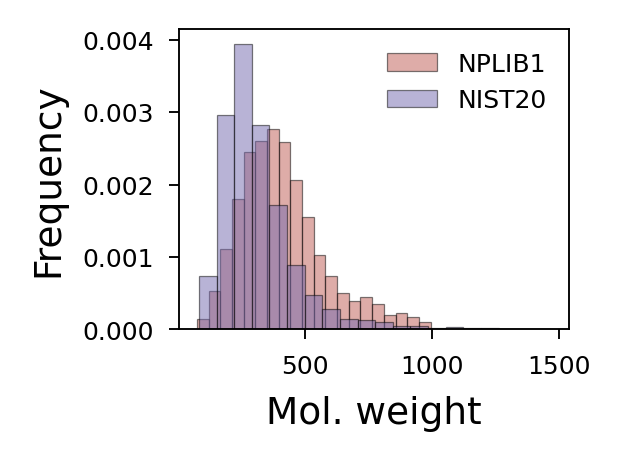

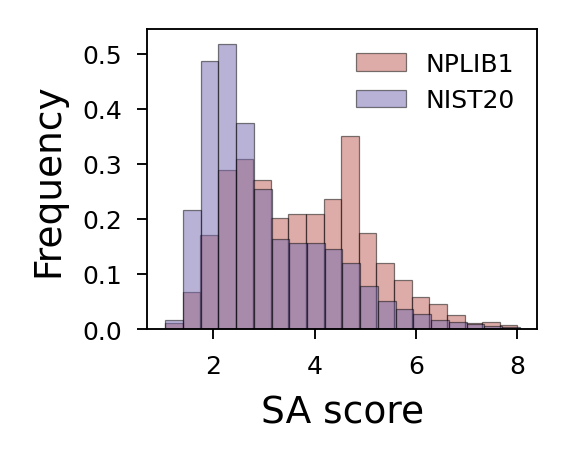

In [8]:
# Create plots for each dataset and report average
# Plot distributions of SA score and molecular weight
# define subplots
gridspec = dict(hspace=0.0, width_ratios=[1, 0.1, 1])
plt_dataset_names = {"canopus_train": "NPLIB1", "nist2020": "NIST20"}
dataset_colors = {"nist2020": "#7369AF", "canopus_train": "#BF5A52"}
plt_metric_names = {"mol_wt": "Mol. weight", "sa_score": "SA score"}

figsize = (1.3, 1)
metrics = ["mol_wt", "sa_score"]
for metric in metrics:
    plot_stats = full_df[metric]
    # Create single plot
    fig, ax = plt.subplots(1, 1, figsize=figsize, dpi=300)
    for dataset, sub_df in full_df.groupby("dataset"):
        ax.hist(
            sub_df[metric],
            bins=20,
            density=True,
            color=dataset_colors[dataset],
            label=plt_dataset_names[dataset],
            alpha=0.5,
            edgecolor="black",
            linewidth=0.3,
        )
    ax.set_xlabel(plt_metric_names[metric])
    ax.set_ylabel("Frequency")
    ax.legend(**legend_params)
    set_size(*figsize, ax)
    fig.savefig(
        res_folder / f"{metric}_dataset.pdf", bbox_inches="tight", transparent=True
    )

## NP Classifier piechart for datasets

In [9]:
dataset_names

['nist20', 'canopus_train_public']

In [10]:
ikey_to_class_files = [
    f"../results/dataset_analyses/{i}/ikey_to_classes.p" for i in dataset_names
]
ikey_to_class = {
    k: v for f in ikey_to_class_files for k, v in pickle.load(open(f, "rb")).items()
}

In [11]:
list(ikey_to_class.values())[0].keys()

dict_keys(['class_results', 'superclass_results', 'pathway_results', 'isglycoside', 'fp1', 'fp2'])

In [12]:
new_df = []
for _, row in full_df.iterrows():
    new_dict = row.to_dict()
    ikey = new_dict["inchikey"]
    classif_out = ikey_to_class[ikey]
    for chem_class in classif_out.get("superclass_results", []):
        temp_dict = dict(**new_dict, chem_class=chem_class)
        new_df.append(temp_dict)
class_df = pd.DataFrame(new_df)

canopus_train
Steroids                               1097
Flavonoids                              785
Coumarins                               698
Tryptophan alkaloids                    652
Small peptides                          607
                                       ... 
Diazotetronic acids and derivatives       4
Proline alkaloids                         3
Miscellaneous polyketides                 2
Docosanoids                               1
Serine alkaloids                          1
Name: chem_class, Length: 66, dtype: int64
nist2020
Small peptides                2123
Anthranilic acid alkaloids    1712
Flavonoids                    1393
Tryptophan alkaloids          1371
Nicotinic acid alkaloids      1279
                              ... 
Miscellaneous polyketides        6
Guanidine alkaloids              6
Polyprenols                      6
Carotenoids (C40)                4
Mitomycin derivatives            1
Name: chem_class, Length: 68, dtype: int64
{
    "Other": 2753,
 

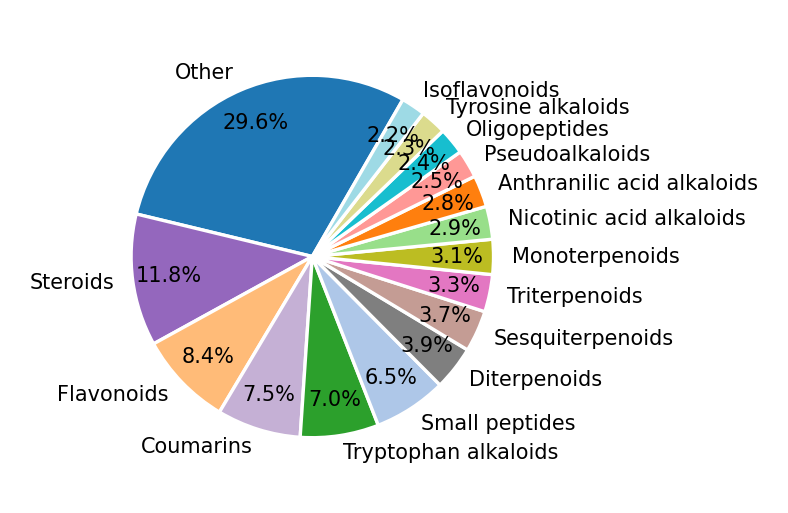

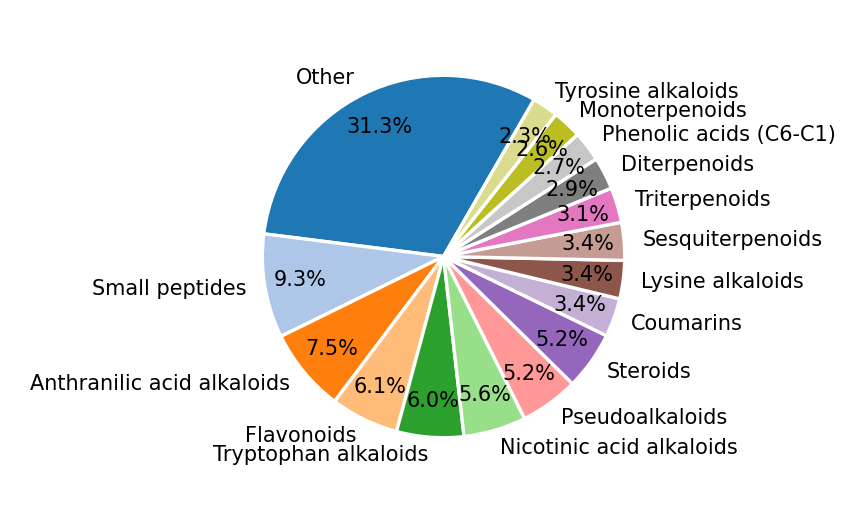

In [13]:
k = 15
dset_to_dict = {}
for dataset, sub_df in class_df.groupby("dataset"):
    print(dataset)
    top_classes = sub_df["chem_class"].value_counts()
    # Sort descending
    top_classes = top_classes.sort_values(ascending=False)
    print(top_classes)
    k_classes = top_classes[:k].index

    other_classes = top_classes[k:].index
    plot_dict = {}
    for ind, count in top_classes.items():
        if ind in k_classes:
            plot_dict[ind] = count
        else:
            plot_dict["Other"] = plot_dict.get("Other", 0) + count
    # Pretty print plot dict
    plot_dict = {
        k: v
        for k, v in sorted(plot_dict.items(), key=lambda item: item[1], reverse=True)
    }
    dset_to_dict[dataset] = plot_dict

# Define a set of all colors for the piechart
all_classes = [kk for k, v in dset_to_dict.items() for kk in v.keys()]
all_classes = set(all_classes)
all_classes = sorted(
    all_classes,
    key=lambda x: max([dd.get(x, 0) for dd in dset_to_dict.values()]),
    reverse=True,
)
# Get color map
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in np.linspace(0, 1, len(all_classes))]
# Create a dictionary of colors for each method
class_to_color = {method: color for method, color in zip(all_classes, colors)}

for dataset, plot_dict in dset_to_dict.items():
    print(json.dumps(plot_dict, indent=4))
    # Create piechart
    figsize = (2, 2)
    plt.figure(figsize=figsize, dpi=300)
    plt.pie(
        plot_dict.values(),
        labels=plot_dict.keys(),
        autopct="%1.1f%%",
        startangle=60,
        textprops={"fontsize": 5},
        # Offset percentages
        pctdistance=0.8,
        colors=[class_to_color[k] for k in plot_dict.keys()],
    )
    plt.savefig(
        res_folder / f"pie_{dataset}.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )